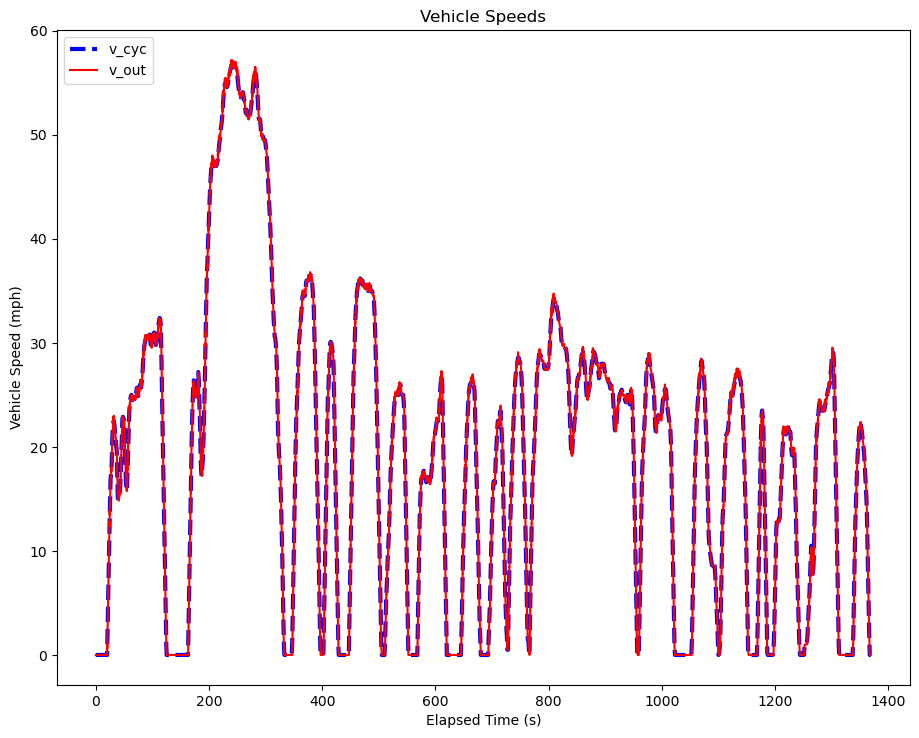

In [1]:
import numpy as np
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import sys
from scipy import interpolate

from driver import Driver
from controller import Controller
from vehicle import Vehicle
from battery_pack import Battery
from electric_motor import ElectricMotor
from gearbox import Gearbox
from front_brakes import FrontBrakes
from rear_brakes import RearBrakes
from front_wheels import FrontWheels
from rear_wheels import RearWheels
# from first_order_filter import MinMaxSlewRateFilter
# from first_order_filter import first_order_filter
# from first_order_filter import butter_lowpass_filter

delta_t = 0.01
vehicle_mass = 3000 * 0.453592  # in kg

k_p = 0.1
k_i = 0.03  # 0.6
k_d = 0  # 2

k_p = 0.25 # ALPHA default
k_i = 0.1  # 0.6

density_air = 1.29
c_drag = 0.24
frontal_area = 3.5
em_efficiency = 0.95
em_gearbox_ratio = 18.63

brake_rear_proportion = 0.4
brake_front_proportion = 0.6

tire_radius = 0.465

driver = Driver(k_p, k_i, k_d, delta_t)
vehicle = Vehicle(vehicle_mass, density_air, c_drag, frontal_area, delta_t)
battery = Battery(0.6, 3, 120, delta_t)
em = ElectricMotor()
em_gearbox = Gearbox(em_efficiency, em_gearbox_ratio)
rear_brakes = RearBrakes(brake_rear_proportion, tire_radius)
front_brakes = FrontBrakes(brake_front_proportion, tire_radius)
rear_wheels = RearWheels(tire_radius)
front_wheels = FrontWheels(tire_radius)

vehspd = spio.loadmat('data/EPA_UDDS_spd.mat', squeeze_me=True)
v_cyc = np.array(vehspd['cycle_speed_mps'])
t_cyc = np.array(vehspd['cycle_time'])
# vehspd = spio.loadmat('data/v_cyc.mat', squeeze_me=True)
# v_cyc = np.array(vehspd['v_cyc'])
# t_cyc = np.array(vehspd['t_cyc'])

f_linear = interpolate.interp1d(t_cyc, v_cyc)

t_cyc = np.arange(0, np.max(t_cyc), delta_t)
v_cyc = f_linear(t_cyc)

dt = t_cyc[1] - t_cyc[0]
# print(dt)

power_req_out = []
battery_power_out = []
em_torque_out = []
front_wheel_torque_out = []
rear_wheel_torque_out = []
force_at_wheel_out = []
front_brake_torque_out = []
rear_brake_torque_out = []
alpha = []
beta = []
v_p = []
v_i = []

v_out = np.zeros(len(t_cyc))

i = 0
for v, t in zip(v_cyc, t_cyc):
    driver_out = driver.compute_step(v, vehicle.velocity)

    # compute necessary battery power
    power_req = driver.alpha * battery.compute_max_power()
    power_req_out.append(power_req)

    b_out = battery.compute_step(power_req)
    battery_power_out.append(b_out['pack_power'])

    em.compute_step(battery.p_pack, em_gearbox.em_force_w)
    em_torque_out.append(em.em_torque)

    rear_brakes.compute_step(rear_wheels.wheel_torque, driver.beta)
    front_brakes.compute_step(front_wheels.wheel_torque, driver.beta)

    em_gearbox.compute_step(em.em_torque, front_brakes.front_brake_w)

    front_wheels.compute_step(
        em_gearbox.torque_out / 2, front_brakes.brake_torque, vehicle.velocity)

    rear_wheels.compute_step(
        em_gearbox.torque_out / 2, rear_brakes.brake_torque, vehicle.velocity)

    vehicle_data = vehicle.compute_step(front_wheels.force_at_wheel +
                                        rear_wheels.force_at_wheel, 0, v)

    # print(v, vehicle_data['velocity'])
    front_wheel_torque_out.append(front_wheels.wheel_torque)
    rear_wheel_torque_out.append(rear_wheels.wheel_torque)
    force_at_wheel_out.append(front_wheels.force_at_wheel +
                              rear_wheels.force_at_wheel)
    front_brake_torque_out.append(front_brakes.brake_torque)
    rear_brake_torque_out.append(rear_brakes.brake_torque)
    alpha.append(driver.alpha)
    beta.append(driver.beta)
    v_p.append(driver_out['v_p'])
    v_i.append(driver_out['v_i'])

    v_out[i] = vehicle_data['velocity']
    i += 1

v_cyc_mph = 2.23694*v_cyc
v_out_mph = 2.23694*np.array(v_out)

fig1, ax = plt.subplots(figsize=(11, 8.5))
plt.plot(t_cyc, v_cyc_mph, 'b--', linewidth=3.0)
plt.plot(t_cyc, v_out_mph, 'r-')
ax.set_title('Vehicle Speeds')
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Vehicle Speed (mph)')

plt.legend(['v_cyc', 'v_out'], loc="upper left")

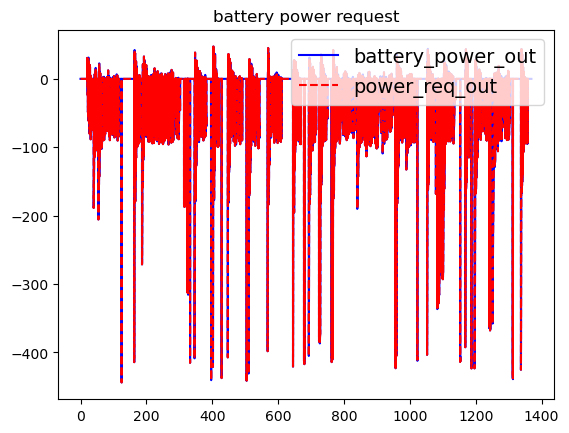

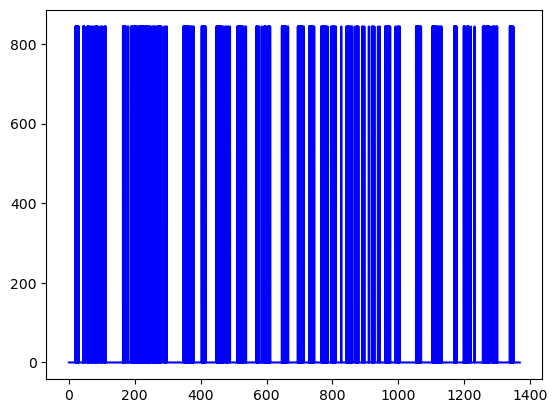

In [2]:
fig2 = plt.figure()
plt.title('battery power request')
plt.plot(t_cyc, battery_power_out, 'b')
plt.plot(t_cyc, power_req_out, 'r--')
# plt.legend('battery', 'power')
plt.legend(['battery_power_out', 'power_req_out'], fontsize=14, loc='upper right')

fig3 = plt.figure()
plt.plot(t_cyc, em_torque_out, 'b')

In [ ]:
fig4 = plt.figure()
plt.title('wheel torque')
plt.plot(t_cyc, rear_wheel_torque_out, 'b')
plt.plot(t_cyc, front_wheel_torque_out, 'r--')


fig5 = plt.figure()
plt.title('wheel force')
plt.plot(t_cyc, force_at_wheel_out, 'b')

In [ ]:
fig6 = plt.figure()
plt.title('brake torque')
plt.plot(t_cyc, front_brake_torque_out, 'b')
plt.plot(t_cyc, rear_brake_torque_out, 'r--')

fig7 = plt.figure()
plt.title('throttle/brake command')
plt.plot(t_cyc, alpha, 'b')
plt.plot(t_cyc, beta, 'r--')

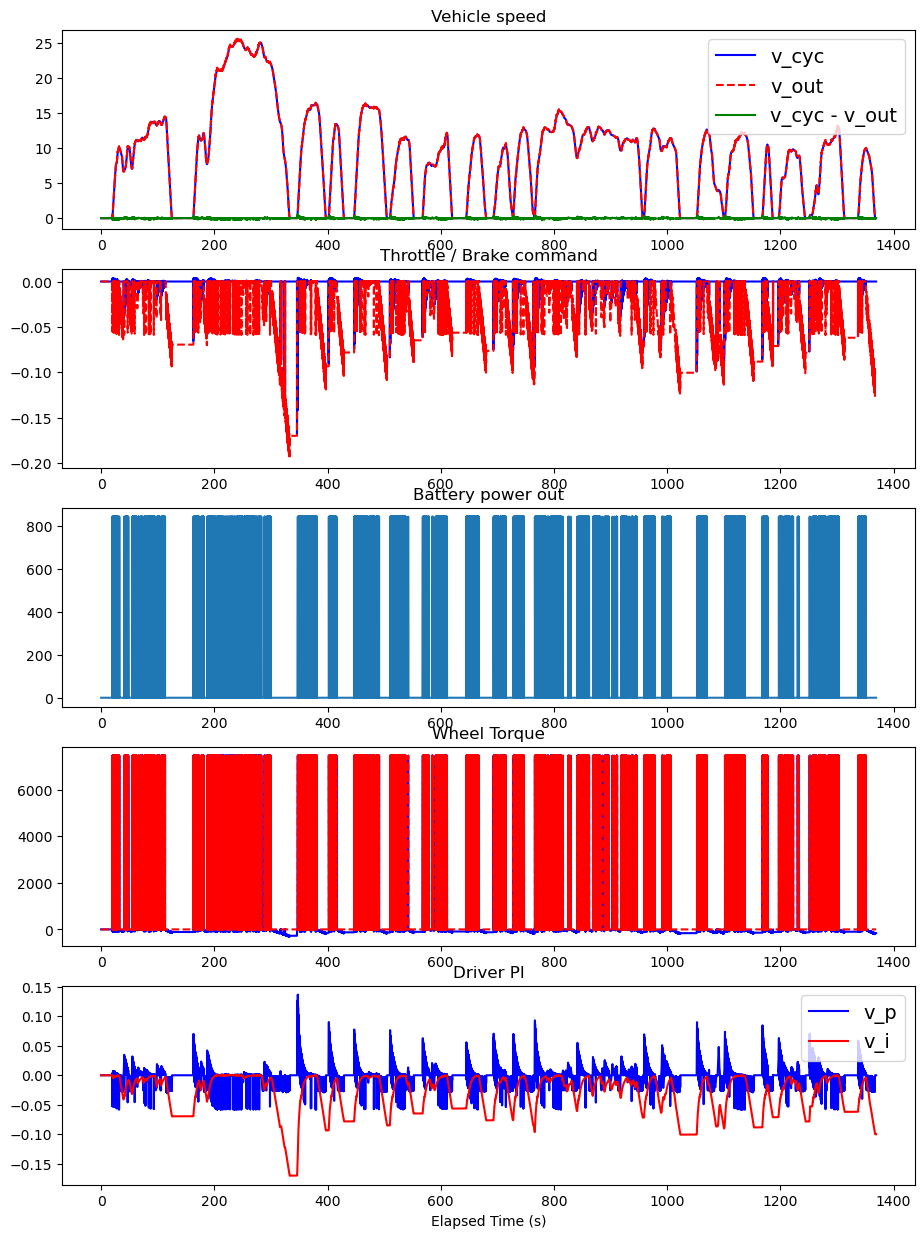

In [3]:
fig8 = plt.figure(figsize=(11, 15))

veh_speed = plt.subplot(511)
veh_speed.set_title('Vehicle speed')
veh_speed.plot(t_cyc, v_cyc, 'b')
veh_speed.plot(t_cyc, v_out, 'r--')
veh_speed.plot(t_cyc, v_cyc - v_out, 'g')
plt.legend(['v_cyc', 'v_out', 'v_cyc - v_out'], fontsize=14, loc='upper right')

acc_brake_cmd = plt.subplot(512, sharex=veh_speed)
acc_brake_cmd.set_title('Throttle / Brake command')
acc_brake_cmd.plot(t_cyc, alpha, 'b')
acc_brake_cmd.plot(t_cyc, beta, 'r--')

power_req = plt.subplot(513, sharex=veh_speed)
power_req.set_title('Battery power out')
power_req.plot(t_cyc, em_torque_out)


wheel_torque = plt.subplot(514, sharex=veh_speed)
wheel_torque.set_title('Wheel Torque')
wheel_torque.plot(t_cyc, front_wheel_torque_out, 'b')
wheel_torque.plot(t_cyc, rear_wheel_torque_out, 'r--')

driver_pi = plt.subplot(515, sharex=veh_speed)
driver_pi.set_title('Driver PI')
driver_pi.plot(t_cyc, v_p, 'b')
driver_pi.plot(t_cyc, v_i, 'r')
plt.xlabel('Elapsed Time (s)')
plt.legend(['v_p', 'v_i'], fontsize=14, loc='upper right')
# plt.show()

plt.show()

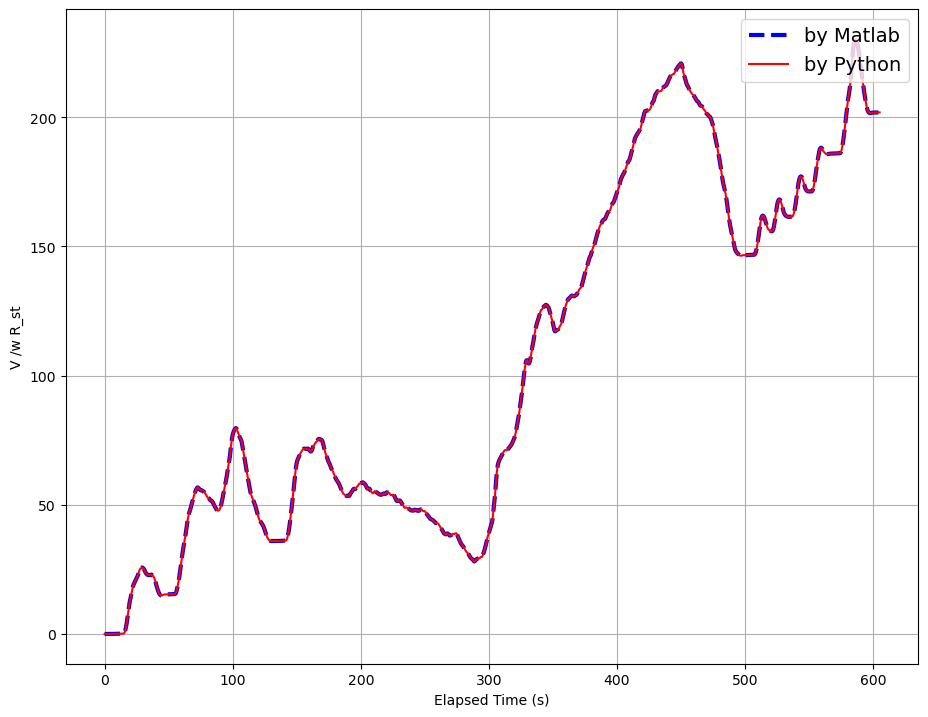

In [9]:
RC_ST_V = spio.loadmat('data/RC_ST_V.mat', squeeze_me=True)
RC_ST_V_t = RC_ST_V['t']
RC_ST_V_in = RC_ST_V['in']
RC_ST_V_out = RC_ST_V['out']
dt = RC_ST_V_t[1] - RC_ST_V_t[0]

RC_ST_V_out1 = np.zeros(len(RC_ST_V_out))
for i in range(len(RC_ST_V_t)):
    t = RC_ST_V_t[i]
    icurr = RC_ST_V_in[i]
    if i == 0:
        RC_ST_V_out1[i] = 0 # icurr * dt
    else:
        RC_ST_V_out1[i] = RC_ST_V_out1[i-1] + icurr * dt

fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(RC_ST_V_t, RC_ST_V_out, 'b--', linewidth=3.0)
plt.plot(RC_ST_V_t, RC_ST_V_out1, 'r-')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('V /w R_st')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper right')

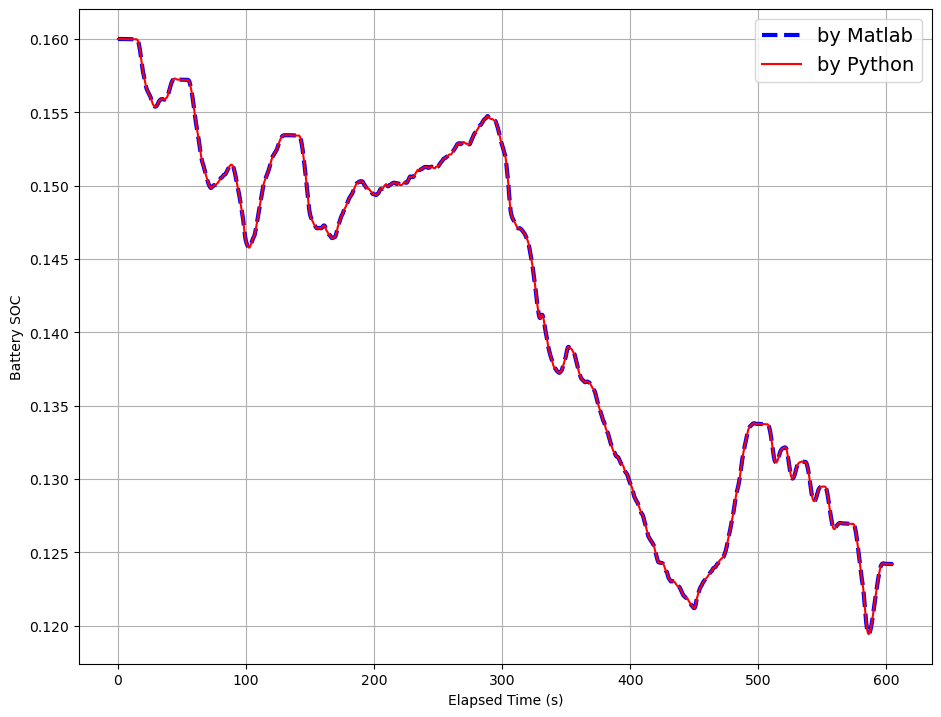

In [8]:
import numpy as np

batt_data = spio.loadmat('data/batt_data.mat', squeeze_me=True)
batt_data_t = batt_data['t']
batt_data_curr_in = batt_data['curr_in']
batt_data_soc = batt_data['soc']
dt = batt_data_t[1] - batt_data_t[0]

batt_soc1 = np.zeros(len(batt_data_t))
batt_capacity_s = 378000 # 52.5Ah * 2 parallel * 3600 sec
for i in range(len(batt_data_t)):
    t = batt_data_t[i]
    icurr = - batt_data_curr_in[i]
    if i == 0:
        batt_soc1[i] = batt_data_soc[0] # icurr * dt
    else:
        batt_soc1[i] = batt_soc1[i-1] + (icurr/batt_capacity_s) * dt

    if batt_soc1[i] > 0.99: batt_soc1[i] = 0.99
        
fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(batt_data_t, batt_data_soc, 'b--', linewidth=3.0)
plt.plot(batt_data_t, batt_soc1, 'r-')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Battery SOC')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper right')

Text(0, 0.5, 'VMT (m)')

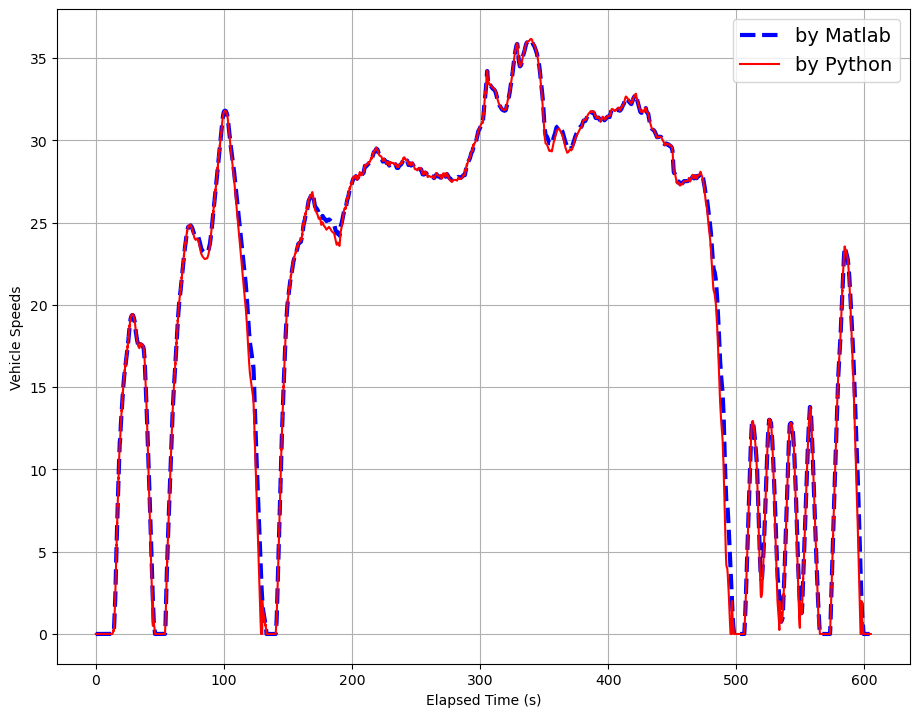

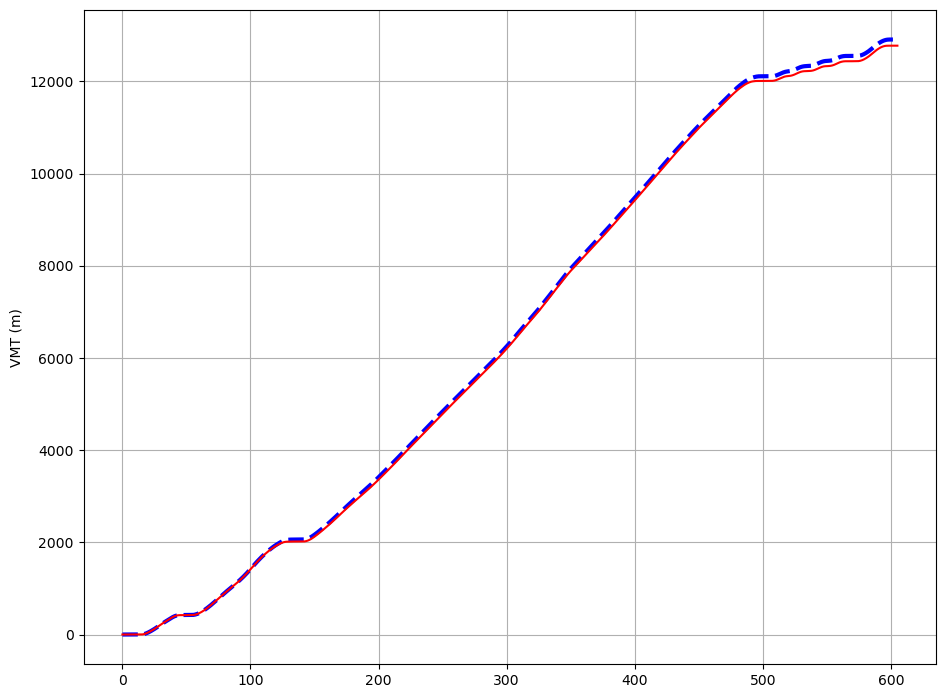

In [3]:
import numpy as np
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import sys
from scipy import interpolate

veh_data = spio.loadmat('data/veh_data.mat', squeeze_me=True)
veh_data_t = veh_data['t']
veh_data_tract_force_N = veh_data['tract_force_N']
veh_data_mass_kg = veh_data['mass_kg']
veh_data_spd_mps_in = veh_data['spd_mps_in']
vehspd_mps = veh_data['spd_mps']
veh_data_dist_m = veh_data['dist_m']
dt = veh_data_t[1] - veh_data_t[0]

vehspd_mps1 = np.zeros(len(veh_data_t))
veh_data_dist_m1 = np.zeros(len(veh_data_t))
# print('dt =', dt, ' size of t_cyc =', len(veh_data_t))

vehspd_mps1[0] = vehspd_mps[0]
veh_data_dist_m1[0] = veh_data_dist_m[0]
for i in range(1, len(veh_data_t)):
    a_out = veh_data_tract_force_N[i] / veh_data_mass_kg[i]
    vehspd_mps1[i] = Vehicle.speed_integrator(dt, a_out, vehspd_mps1[i-1], vehspd_mps[i])
    
    # a_out_i = veh_data_tract_force_N[i] / veh_data_mass_kg[i]
    # if i == 0:
    #     vehspd_mps1[i] = 0
    #     veh_data_dist_m1[i] = 0
    # else:
    #     vehspd_mps1[i] = vehspd_mps1[i - 1] + a_out_i * dt
    #     a_delta = ((vehspd_mps[i] - vehspd_mps[i - 1]) / dt) - a_out_i
    #     v_delta = vehspd_mps1[i] - vehspd_mps[i]
    #     if (vehspd_mps1[i] > 0) and (a_out_i != a_delta) and (np.abs(v_delta) > 0.01):
    #         if (v_delta > 0) and (abs(a_delta) <= 0.1):
    #             vehspd_mps1[i] = vehspd_mps1[i] - v_delta
    #         elif (v_delta < 0) and (abs(a_delta) <= 0.1):
    #             vehspd_mps1[i] = vehspd_mps1[i] + 0.1

    #     if (vehspd_mps1[i] < 0.1): vehspd_mps1[i] = 0.0

    # if (vehspd_mps1[i] < 0.5) and (vehspd_mps[i] > 0.5) and (vehspd_mps[i] < 2.0): vehspd_mps1[i] = vehspd_mps[i]

    veh_data_dist_m1[i] = veh_data_dist_m1[i - 1] + vehspd_mps1[i] * dt

fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(veh_data_t, vehspd_mps, 'b--', linewidth=3.0)
plt.plot(veh_data_t, vehspd_mps1, 'r-')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Vehicle Speeds')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper right')

fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(veh_data_t, veh_data_dist_m, 'b--', linewidth=3.0)
plt.plot(veh_data_t, veh_data_dist_m1, 'r-')

plt.grid()
# plt.xlabel('Elapsed Time (s)')
plt.ylabel('VMT (m)')
# plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper left')

In [ ]:
max_torque_t_map = array([421.9751032 , 421.9751032 , 421.9751032 , 421.9751032 ,
       421.9751032 , 421.9751032 , 421.9751032 , 421.9751032 ,
       421.9751032 , 421.9751032 , 421.9751032 , 421.9751032 ,
       421.9751032 , 421.9751032 , 421.9751032 , 421.9751032 ,
       421.9751032 , 421.9751032 , 421.9751032 , 421.9751032 ,
       421.9751032 , 421.9751032 , 421.9751032 , 421.9751032 ,
       421.9751032 , 413.44859596, 397.54672689, 382.82277404,
       369.15053211, 356.42120342, 344.54049664, 333.42628707,
       323.0067156 , 313.21863331, 304.00632056, 295.32042569,
       287.11708053, 279.35715944, 272.00565524, 265.03115126,
       258.40537248, 252.10280242, 246.10035474, 240.37709068,
       234.91397498, 229.69366442, 224.70032389, 219.91946594,
       215.3378104 , 210.94316121, 206.72429798, 202.67088037,
       198.77336344, 195.02292262, 191.41138702, 187.93117998,
       184.57526606, 181.33710349, 178.21060171, 175.19008304,
       172.27024832, 169.44614589, 166.71314353, 164.06690316,
       161.5033578 , 159.01869076, 156.60931665, 154.27186417,
       152.00316028, 149.80021593, 147.66021284, 145.58049154,
       143.55854027, 141.59198492, 139.67857972, 137.81619865,
       134.83701779, 130.94753775, 127.50032289, 124.14037929,
       120.96157555, 117.87167736, 114.89398265, 112.05547975,
       109.28456024, 106.65981712, 104.1162528 , 101.65566187,
        99.32466945,  97.04605888,  94.88469527,  92.79962579,
        90.77340451,  88.87005384,  87.00719999,  85.2373205 ,
        83.54085711,  81.88266994,  80.33420987,  78.81703181])
max_torque_w_map = array([   0.        ,   11.60966574,   23.21933148,   34.82899722,
         46.43866296,   58.0483287 ,   69.65799444,   81.26766018,
         92.87732592,  104.48699166,  116.0966574 ,  127.70632314,
        139.31598889,  150.92565463,  162.53532037,  174.14498611,
        185.75465185,  197.36431759,  208.97398333,  220.58364907,
        232.19331481,  243.80298055,  255.41264629,  267.02231203,
        278.63197777,  290.24164351,  301.85130925,  313.46097499,
        325.07064073,  336.68030647,  348.28997221,  359.89963795,
        371.50930369,  383.11896943,  394.72863517,  406.33830092,
        417.94796666,  429.5576324 ,  441.16729814,  452.77696388,
        464.38662962,  475.99629536,  487.6059611 ,  499.21562684,
        510.82529258,  522.43495832,  534.04462406,  545.6542898 ,
        557.26395554,  568.87362128,  580.48328702,  592.09295276,
        603.7026185 ,  615.31228424,  626.92194998,  638.53161572,
        650.14128146,  661.75094721,  673.36061295,  684.97027869,
        696.57994443,  708.18961017,  719.79927591,  731.40894165,
        743.01860739,  754.62827313,  766.23793887,  777.84760461,
        789.45727035,  801.06693609,  812.67660183,  824.28626757,
        835.89593331,  847.50559905,  859.11526479,  870.72493053,
        882.33459627,  893.94426201,  905.55392775,  917.16359349,
        928.77325924,  940.38292498,  951.99259072,  963.60225646,
        975.2119222 ,  986.82158794,  998.43125368, 1010.04091942,
       1021.65058516, 1033.2602509 , 1044.86991664, 1056.47958238,
       1068.08924812, 1079.69891386, 1091.3085796 , 1102.91824534,
       1114.52791108, 1126.13757682, 1137.74724256, 1149.3569083 ])

np.interp(power_request * em_f_w, self.max_torque_w_map, self.max_torque_t_map) * 2

        self.ocv_map = np.array(mat['OCV_curve'])
 array([2.8       , 3.0021414 , 3.21372124, 3.38258747, 3.46204864,
       3.53063695, 3.54835989, 3.56323892, 3.58161869, 3.6056933 ,
       3.63440563, 3.66484733, 3.69540045, 3.72487228, 3.75232322,
       3.77676621, 3.79799913, 3.81592251, 3.83111573, 3.84432037,
       3.8563857 , 3.86770371, 3.87865739, 3.88951062, 3.90070482,
       3.91308772, 3.92769594, 3.94581819, 3.96658256, 3.9870598 ,
       4.00457814, 4.0185052 , 4.03020426, 4.04027267, 4.04923127,
       4.0576721 , 4.06635519, 4.07641443, 4.08911508, 4.10578038,
       4.12654317, 4.15      ])

soc_map = np.linspace(0, 1, len(self.ocv_map))
array([0.        , 0.02439024, 0.04878049, 0.07317073, 0.09756098,
       0.12195122, 0.14634146, 0.17073171, 0.19512195, 0.2195122 ,
       0.24390244, 0.26829268, 0.29268293, 0.31707317, 0.34146341,
       0.36585366, 0.3902439 , 0.41463415, 0.43902439, 0.46341463,
       0.48780488, 0.51219512, 0.53658537, 0.56097561, 0.58536585,
       0.6097561 , 0.63414634, 0.65853659, 0.68292683, 0.70731707,
       0.73170732, 0.75609756, 0.7804878 , 0.80487805, 0.82926829,
       0.85365854, 0.87804878, 0.90243902, 0.92682927, 0.95121951,
       0.97560976, 1.        ])

